# STEP 1: Loading and Preprocess Data

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
from sklearn.metrics import r2_score

# Load the dataset
file_path = 'Resources/CMPD_VIOLENT_DATES.csv'
crime_data = pd.read_csv(file_path)

# Preprocess the Data
crime_data['DATE_REPORTED'] = pd.to_datetime(crime_data['DATE_REPORTED'])
daily_crime = crime_data.groupby('DATE_REPORTED').size().reset_index(name='Crime_Count')

# Create a complete date range and fill missing dates with 0
date_range = pd.date_range(start='2017-01-01', end='2024-11-20')
daily_crime = daily_crime.set_index('DATE_REPORTED').reindex(date_range, fill_value=0).reset_index()
daily_crime.columns = ['DATE_REPORTED', 'Crime_Count']

# Verify that the data is complete and in the correct format
print(f"Data starts at {daily_crime['DATE_REPORTED'].min()} and ends at {daily_crime['DATE_REPORTED'].max()}")
print(f"Data type of 'DATE_REPORTED': {daily_crime['DATE_REPORTED'].dtype}")
print(f"Number of missing values: {daily_crime.isna().sum().sum()}")


Data starts at 2017-01-01 00:00:00 and ends at 2024-11-20 00:00:00
Data type of 'DATE_REPORTED': datetime64[ns]
Number of missing values: 0


# STEP 2: Decompose Time Series

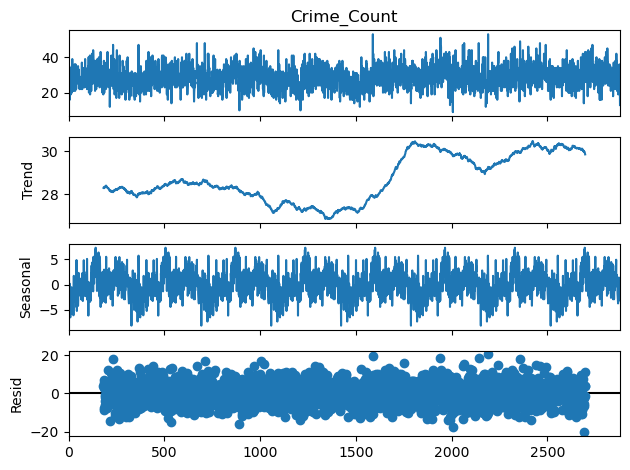

In [9]:
# Time-Series Decomposition
decomposition = seasonal_decompose(daily_crime['Crime_Count'], period=365, model='additive')
decomposition.plot()
plt.savefig('CMPD_CRIME_By_Month.png')
plt.show()



# STEP 3: Fit ARIMA Model WITH IMPROVEMENTS

In [4]:
# Aggregate to monthly data to reduce noise
monthly_crime = daily_crime.resample('ME', on='DATE_REPORTED').sum()

# Fit SARIMA model with manual parameters (adjust as needed)
sarima_model = SARIMAX(
    monthly_crime['Crime_Count'],
    order=(2, 1, 0),
    seasonal_order=(0, 1, 1, 12),  # Seasonal terms for monthly data
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit()

# Print model summary
print(sarima_results.summary())




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11455D+00    |proj g|=  1.34518D-01

At iterate    5    f=  4.09237D+00    |proj g|=  4.17780D-03

At iterate   10    f=  4.08111D+00    |proj g|=  4.57288D-02

At iterate   15    f=  4.07505D+00    |proj g|=  1.21443D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   6.481D-06   4.075D+00
  F =   4.0747123811097756     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

 This problem is unconstrained.


# STEP 4: Evaluate the Model with Improved Metrics

/var/folders/z3/mxhxwwgj7bb1sd23lpfhh6h80000gn/T/ipykernel_45988/3928784145.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted'] = sarima_results.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R-squared: 0.21089301981911734
Mean Absolute Error (MAE): 73.42347266791323
Root Mean Squared Error (RMSE): 105.76593366205641


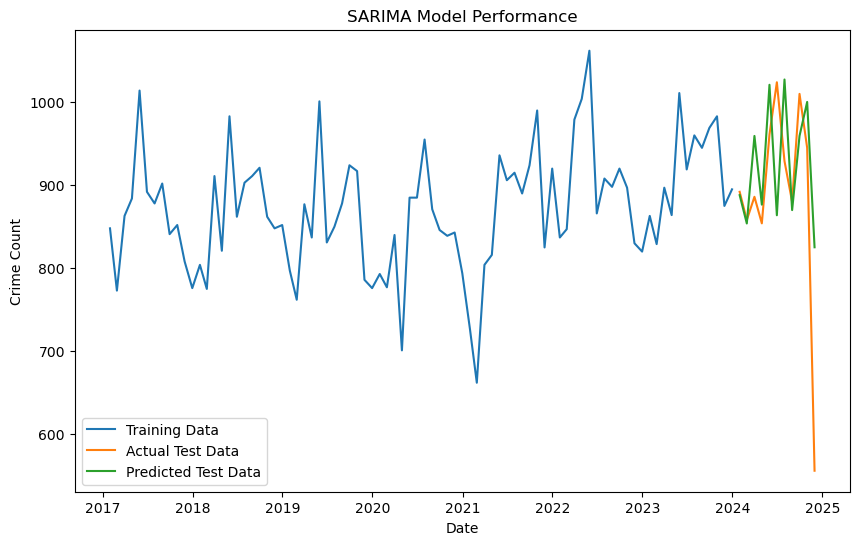

In [12]:
# Split the data into train and test sets (monthly aggregated data)
train = monthly_crime[monthly_crime.index < '2024-01-01']
test = monthly_crime[monthly_crime.index >= '2024-01-01']

# Make predictions on the test set
test['Predicted'] = sarima_results.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean

# Calculate performance metrics
mae = mean_absolute_error(test['Crime_Count'], test['Predicted'])
rmse = mean_squared_error(test['Crime_Count'], test['Predicted'], squared=False)
r2 = r2_score(test['Crime_Count'], test['Predicted'])

print(f"R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Crime_Count'], label='Training Data')
plt.plot(test.index, test['Crime_Count'], label='Actual Test Data')
plt.plot(test.index, test['Predicted'], label='Predicted Test Data')
plt.legend()
plt.title('SARIMA Model Performance')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.savefig('CMPD_CRIME_Model_Performance.png')
plt.show()


# STEP 5: Generate Forecast with Improved SARIMA Model

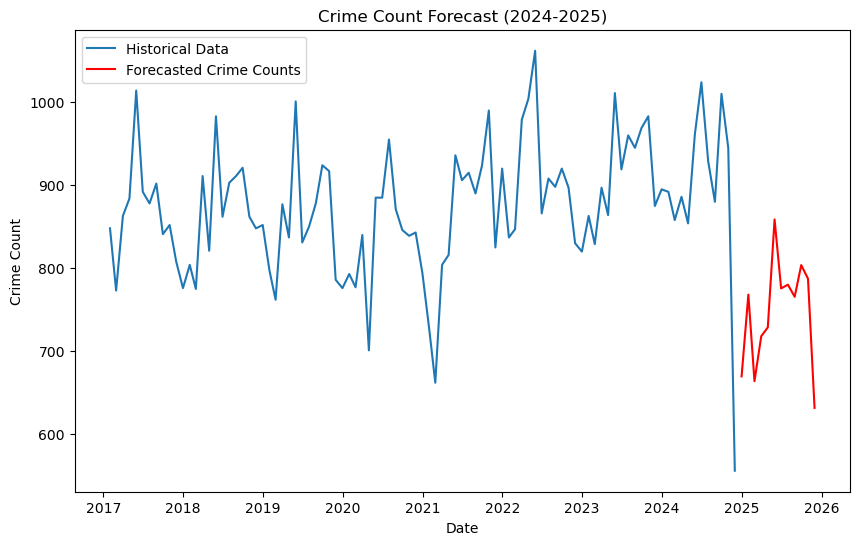

In [13]:
# Forecast for the next year (2024-2025)
forecast_steps = 12  # Forecast 12 months ahead
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start='2024-12-01', periods=forecast_steps, freq='ME')  # Use 'ME' for monthly frequency
forecast_values = forecast.predicted_mean

# Visualize the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_crime.index, monthly_crime['Crime_Count'], label='Historical Data')
plt.plot(forecast_index, forecast_values, label='Forecasted Crime Counts', color='red')
plt.title('Crime Count Forecast (2024-2025)')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.savefig('CMPD_CRIME_Forecast_2024-2025.png')
plt.show()
